In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import os
from pathlib import Path
import re
import seaborn as sns
from scipy import stats
import scipy

/Users/ljy/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [27]:
def plot_cdf(data, bins_count):
    count, bins_count = np.histogram(data, bins=bins_count)
    pdf = count / sum(count)
    cdf = np.cumsum(pdf)
    plt.plot(bins_count[1:], pdf, color="red", label="PDF")
    plt.plot(bins_count[1:], cdf, label="CDF")
    plt.legend()
def plot_hist_ecdf(data, bins_count, compiler, ratio):
    fig = plt.figure(figsize=(8,6))
    ax = sns.histplot(data, kde=False, stat='probability', bins=20).set(title=f'{compiler}_{ratio}')
    ax = sns.ecdfplot(data, label = 'ecdf')
    ax.set(xlabel='percentage(%)', ylabel='probability')
    fig.legend(loc='upper right')


def is_float(string):
    try:
        float(string)
        return True
    except ValueError:
        return False
def get_data(compiler_name, if_long, ratio):
    data = []
    data_noNan = []
    NaN_count = 0
    NaN_functions = []
    if(if_long):
        trace = 'tracefiles_long'
    else:
        trace = 'tracefile'
    path = Path(f'../optimizations/{compiler_name}/{trace}')
#     print('path: ', path)
    contracts = [f for f in path.iterdir() if f.is_dir()]
    for contract in contracts:
        if(os.path.basename(contract) == 'bnbCompact'):
            continue;
        functions = [f for f in contract.iterdir() if f.is_dir()]
        for function in functions:
            file = function.joinpath("opcode.txt")
            if file.is_file():
                with open(function.joinpath("opcode.txt")) as file:
                    if (ratio == 'write_over_read'):
                        line_write = file.readlines()[-12]
                        file.seek(0)
                        line_read = file.readlines()[-13]
                        if(line_write.startswith('storage_write_cost') and line_read.startswith('storage_read_cost')):
                            write = re.split(': |\n', line_write)[1]
                            read = re.split(': |\n', line_read)[1]
                            if (int(read) == 0):
                                NaN_functions.append(function)
                                NaN_count += 1
                            else:
                                wr = round((int(write) / int(read)), 2)
                                data.append(wr)
                                
                    else:
                        if (ratio == 'storage_over_op'):
                            line = file.readlines()[-4]
                        elif (ratio == 'read_over_op'):
                            line = file.readlines()[-3]
                        elif (ratio == 'write_over_op'):
                            line = file.readlines()[-2]
                        elif (ratio == 'read_over_write'):
                            line = file.readlines()[-1]
                        if (line.startswith(ratio)):
                            perc = re.split(': |%', line)[1]
                            if (perc == 'NaN'):
                                NaN_functions.append(function)
                                NaN_count += 1
#                                 data.append(10000000)
                            if(is_float(perc) and perc != 'NaN'):
                                data.append(float(perc))
                                data_noNan.append(float(perc))
    print(f'NaN({compiler_name}_{ratio}): ', NaN_count, NaN_functions)
    print(f'data_length({compiler_name}_{ratio})', len(data))
#     print(f'data({compiler_name}_{ratio})', data)
#     x_min = min(data_noNan)
#     x_max = max(data_noNan)
    return data

def plot_grouop(compiler, bins):
    data_storage_op = get_data(compiler, True, 'storage_over_op')
    data_read_op = get_data(compiler, True, 'read_over_op')
    data_write_op = get_data(compiler, True, 'write_over_op')
    data_read_write = get_data(compiler, True, 'read_over_write')
    data_write_read = get_data(compiler, True, 'write_over_read')
    fig, axes = plt.subplots(3, 2, figsize=(15, 17))
    fig.suptitle(f'{compiler} Ratios Distribution')

    fig1 = sns.histplot(ax=axes[0, 0], data=data_storage_op, kde=False, stat='probability', bins=bins).set(title=f'dsc_storage_over_op')
    fig1 = sns.ecdfplot(ax=axes[0, 0], data=data_storage_op, label = 'ecdf')
    fig1.set(xlabel='percentage(%)', ylabel='probability')

    fig2 = sns.histplot(ax=axes[0, 1], data=data_read_op, kde=False, stat='probability', bins=bins).set(title=f'dsc_read_over_op')
    fig2 = sns.ecdfplot(ax=axes[0, 1], data=data_read_op, label = 'ecdf')
    fig2.set(xlabel='percentage(%)', ylabel='probability')

    fig3 = sns.histplot(ax=axes[1, 0], data=data_write_op, kde=False, stat='probability', bins=bins).set(title=f'dsc_write_over_op')
    fig3 = sns.ecdfplot(ax=axes[1, 0], data=data_write_op, label = 'ecdf')
    fig3.set(xlabel='percentage(%)', ylabel='probability')

    fig4 = sns.histplot(ax=axes[1, 1], data=data_read_write, kde=False, stat='probability', bins=bins).set(title=f'dsc_read_over_write')
    fig4 = sns.ecdfplot(ax=axes[1, 1], data=data_read_write, label = 'ecdf')
    fig4.set(xlabel='percentage(%)', ylabel='probability')

    fig5 = sns.histplot(ax=axes[2, 0], data=data_write_read, kde=False, stat='probability', bins=bins).set(title=f'dsc_write_over_read')
    fig5 = sns.ecdfplot(ax=axes[2, 0], data=data_write_read, label = 'ecdf')
    fig5.set(xlabel='percentage(%)', ylabel='probability')

def plot_grouop_ratio(ratio, bins):
    dsc_ratio = get_data('dsc', True, ratio)
    fused_ratio = get_data('dsc-fused-operator', True, ratio)
    references_ratio = get_data('references', True, ratio)
    fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True)
    fig.suptitle(f'compilers {ratio} Distribution')

    fig1 = sns.histplot(ax=axes[0, 0], data=dsc_ratio, kde=False, stat='probability', bins=bins).set(title=f'dsc_{ratio}')
    fig1 = sns.ecdfplot(ax=axes[0, 0], data=dsc_ratio, label = 'ecdf')
    fig1.set(xlabel='percentage(%)', ylabel='probability')

    fig2 = sns.histplot(ax=axes[0, 1], data=fused_ratio, kde=False, stat='probability', bins=bins).set(title=f'fused_{ratio}')
    fig2 = sns.ecdfplot(ax=axes[0, 1], data=fused_ratio, label = 'ecdf')
    fig2.set(xlabel='percentage(%)', ylabel='probability')

    fig3 = sns.histplot(ax=axes[1, 0], data=references_ratio, kde=False, stat='probability', bins=bins).set(title=f'references_{ratio}')
    fig3 = sns.ecdfplot(ax=axes[1, 0], data=references_ratio, label = 'ecdf')
    fig3.set(xlabel='percentage(%)', ylabel='probability')

NaN(dsc_storage_over_op):  0 []
data_length(dsc_storage_over_op) 76
NaN(dsc_read_over_op):  0 []
data_length(dsc_read_over_op) 76
NaN(dsc_write_over_op):  0 []
data_length(dsc_write_over_op) 76
NaN(dsc_read_over_write):  2 [PosixPath('../optimizations/dsc/tracefiles_long/crowdsale/withdraw'), PosixPath('../optimizations/dsc/tracefiles_long/bnb/withdrawEther')]
data_length(dsc_read_over_write) 74
NaN(dsc_write_over_read):  0 []
data_length(dsc_write_over_read) 76


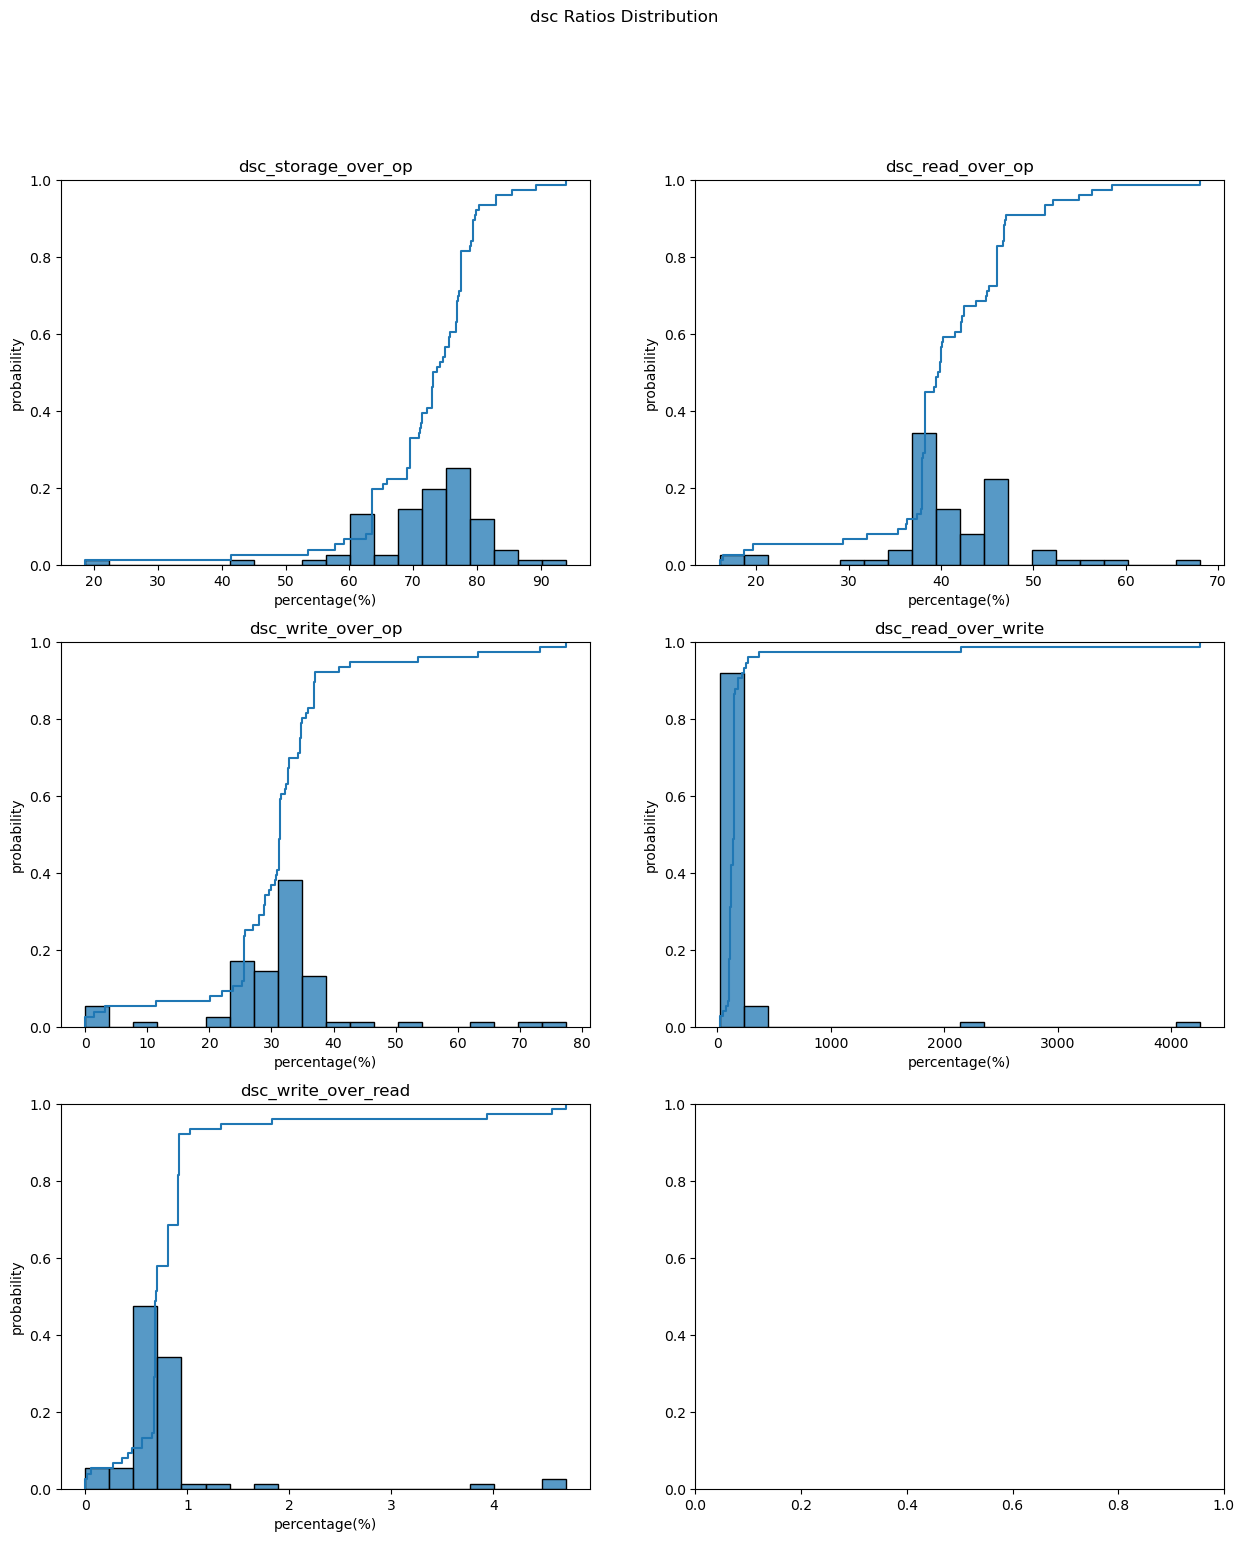

In [14]:
plot_grouop('dsc', 20)

NaN(dsc-fused-operator_storage_over_op):  0 []
data_length(dsc-fused-operator_storage_over_op) 70
NaN(dsc-fused-operator_read_over_op):  0 []
data_length(dsc-fused-operator_read_over_op) 70
NaN(dsc-fused-operator_write_over_op):  0 []
data_length(dsc-fused-operator_write_over_op) 70
NaN(dsc-fused-operator_read_over_write):  2 [PosixPath('../optimizations/dsc-fused-operator/tracefiles_long/crowdsale/withdraw'), PosixPath('../optimizations/dsc-fused-operator/tracefiles_long/bnb/withdrawEther')]
data_length(dsc-fused-operator_read_over_write) 68
NaN(dsc-fused-operator_write_over_read):  0 []
data_length(dsc-fused-operator_write_over_read) 70


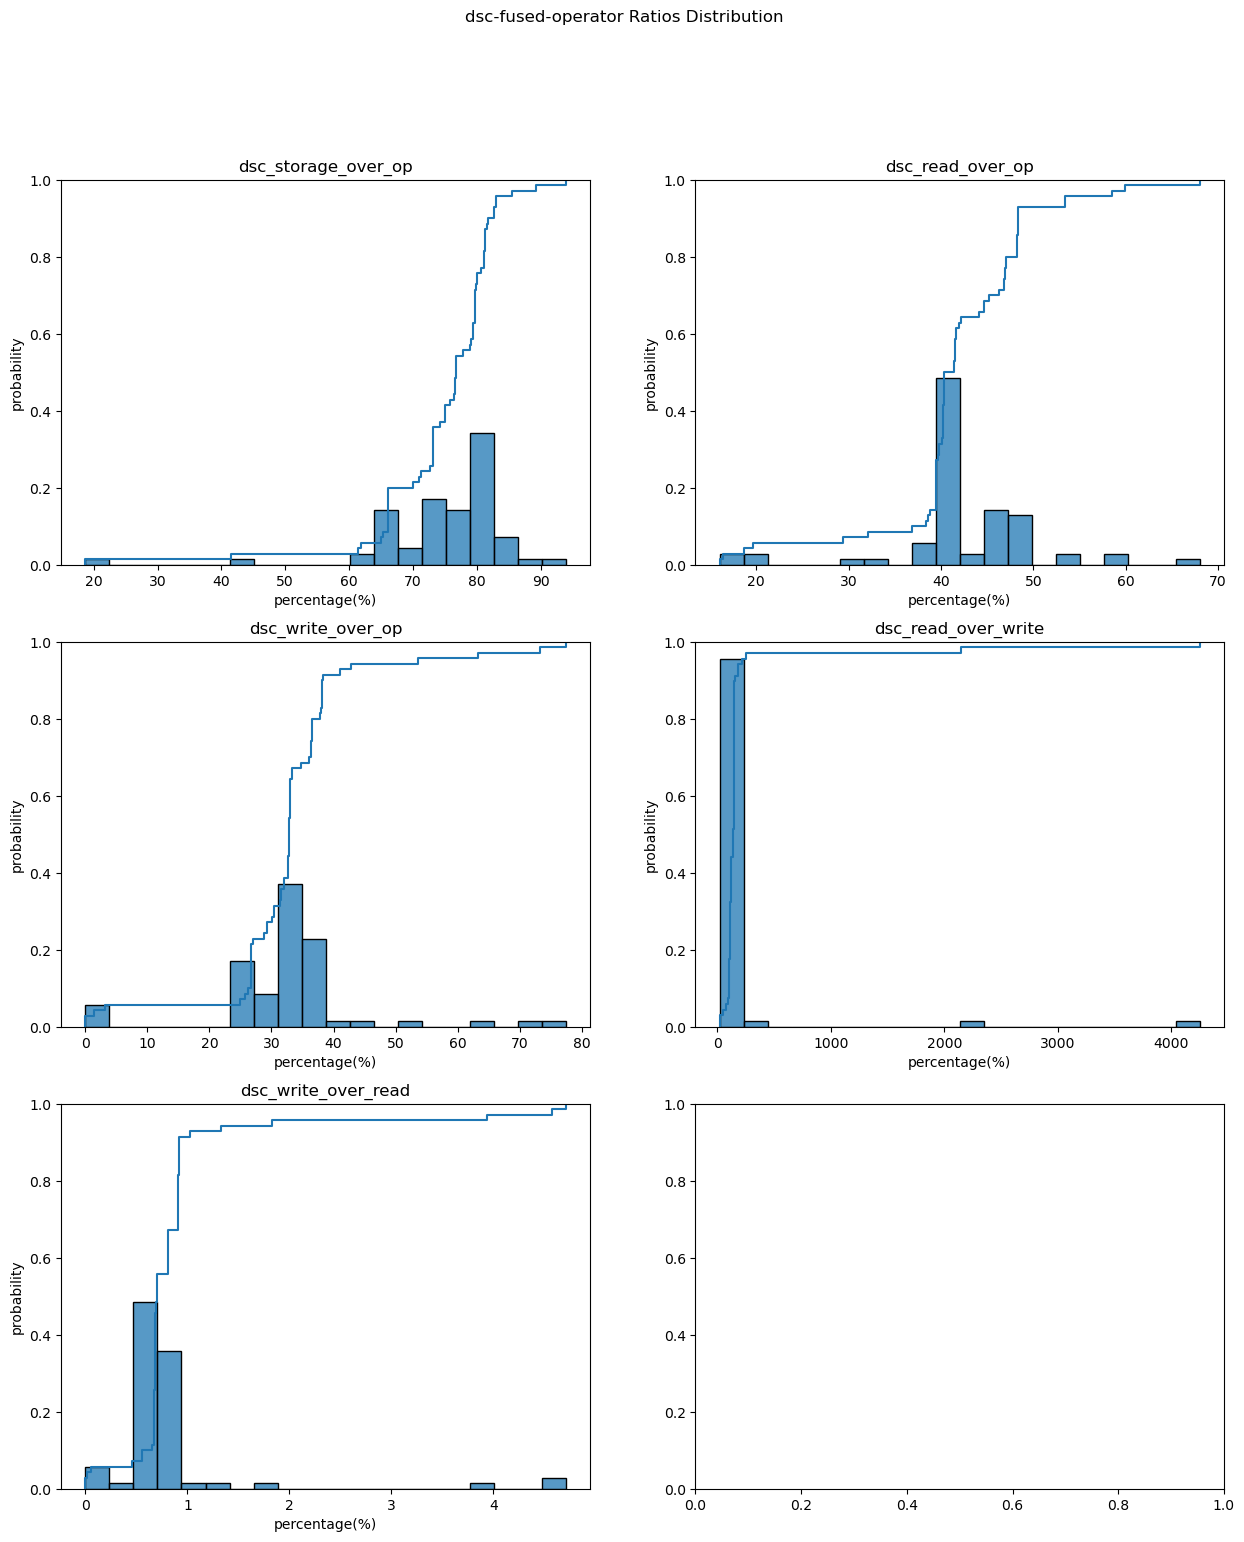

In [15]:
plot_grouop('dsc-fused-operator', 20)

NaN(references_storage_over_op):  0 []
data_length(references_storage_over_op) 96
NaN(references_read_over_op):  0 []
data_length(references_read_over_op) 96
NaN(references_write_over_op):  0 []
data_length(references_write_over_op) 96
NaN(references_read_over_write):  1 [PosixPath('../optimizations/references/tracefiles_long/bnb/withdrawEther')]
data_length(references_read_over_write) 95
NaN(references_write_over_read):  6 [PosixPath('../optimizations/references/tracefiles_long/controllable/approve'), PosixPath('../optimizations/references/tracefiles_long/erc777/approve'), PosixPath('../optimizations/references/tracefiles_long/link/approve'), PosixPath('../optimizations/references/tracefiles_long/shib/approve'), PosixPath('../optimizations/references/tracefiles_long/bnb/approve'), PosixPath('../optimizations/references/tracefiles_long/ltcSwapAsset/approve')]
data_length(references_write_over_read) 90


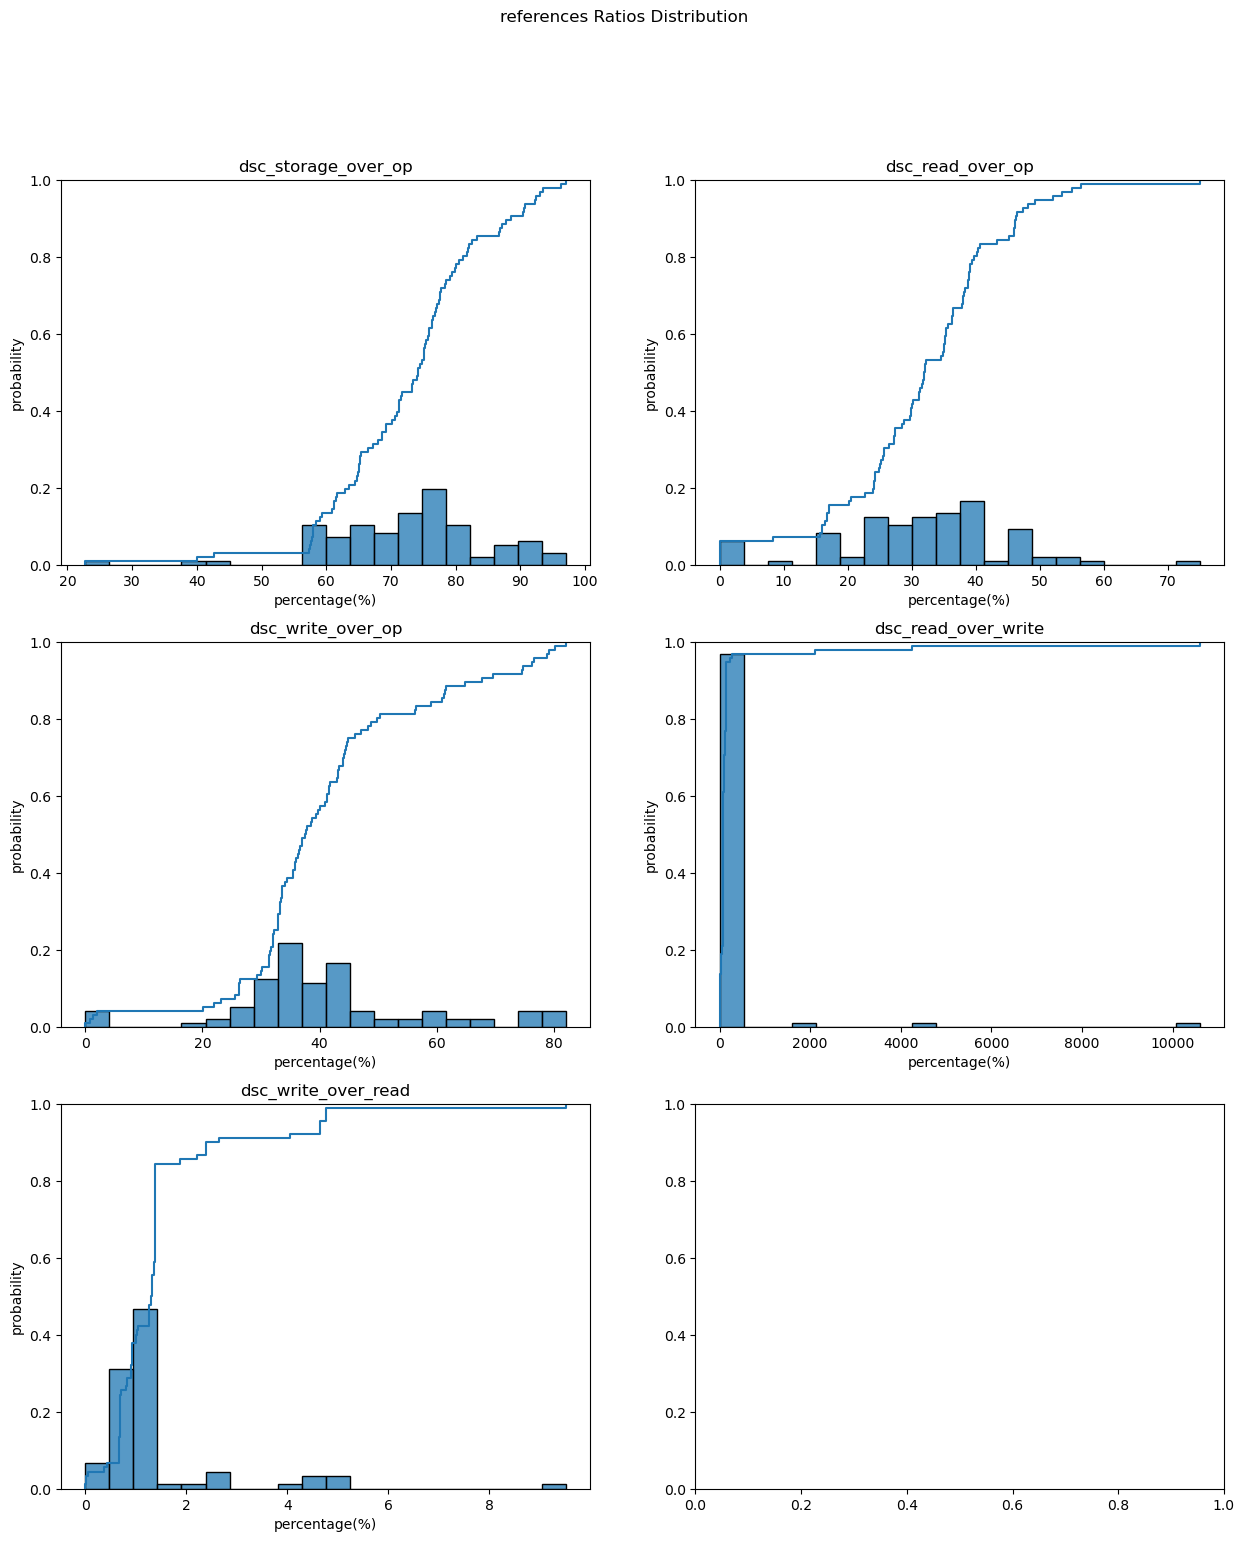

In [16]:
plot_grouop('references', 20)

NaN(dsc_storage_over_op):  0 []
data_length(dsc_storage_over_op) 76
NaN(dsc-fused-operator_storage_over_op):  0 []
data_length(dsc-fused-operator_storage_over_op) 70
NaN(references_storage_over_op):  0 []
data_length(references_storage_over_op) 96


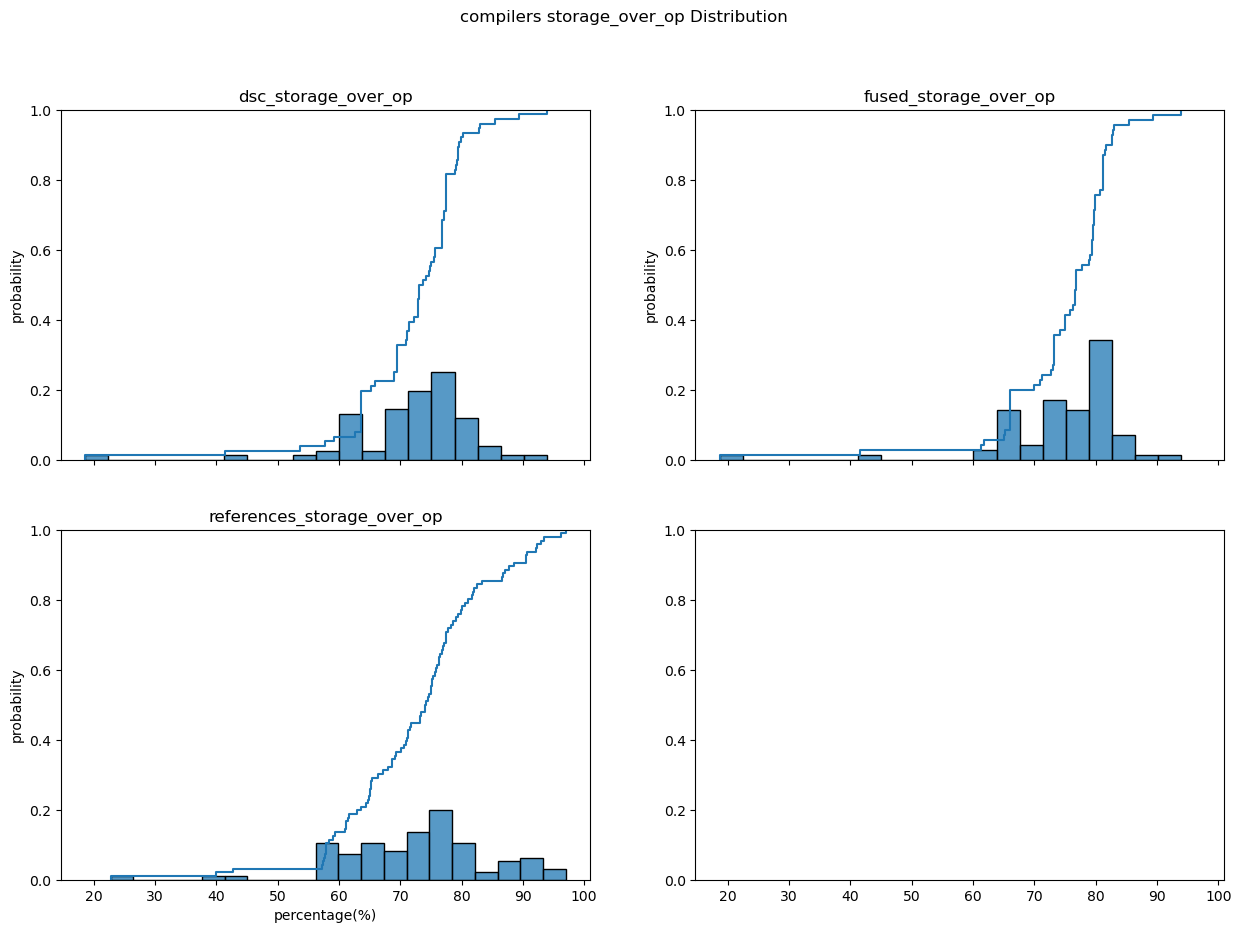

In [28]:
plot_grouop_ratio('storage_over_op', 20)

NaN(dsc_write_over_op):  0 []
data_length(dsc_write_over_op) 76
NaN(dsc-fused-operator_write_over_op):  0 []
data_length(dsc-fused-operator_write_over_op) 70
NaN(references_write_over_op):  0 []
data_length(references_write_over_op) 96


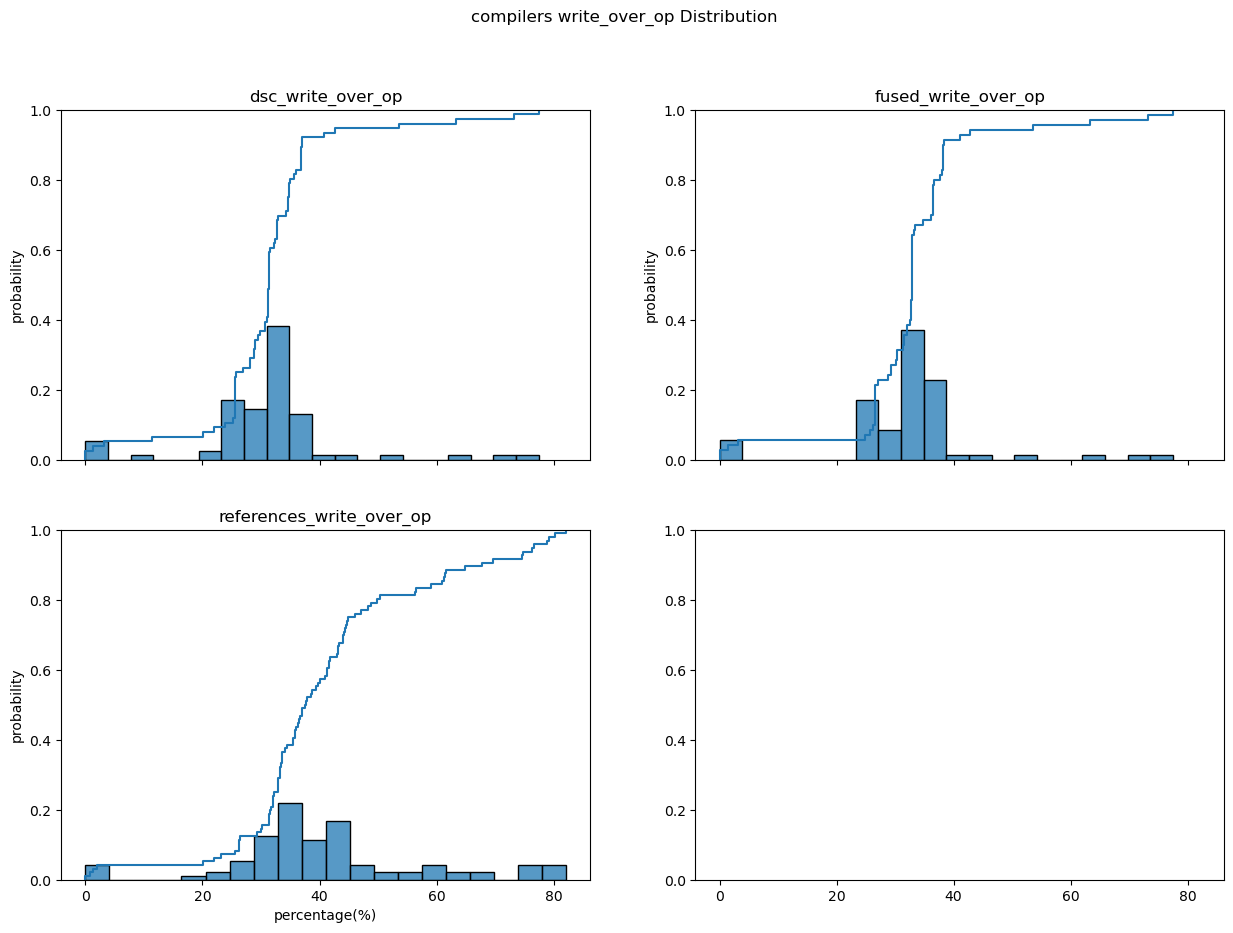

In [29]:
plot_grouop_ratio('write_over_op', 20)

NaN(dsc_read_over_op):  0 []
data_length(dsc_read_over_op) 76
NaN(dsc-fused-operator_read_over_op):  0 []
data_length(dsc-fused-operator_read_over_op) 70
NaN(references_read_over_op):  0 []
data_length(references_read_over_op) 96


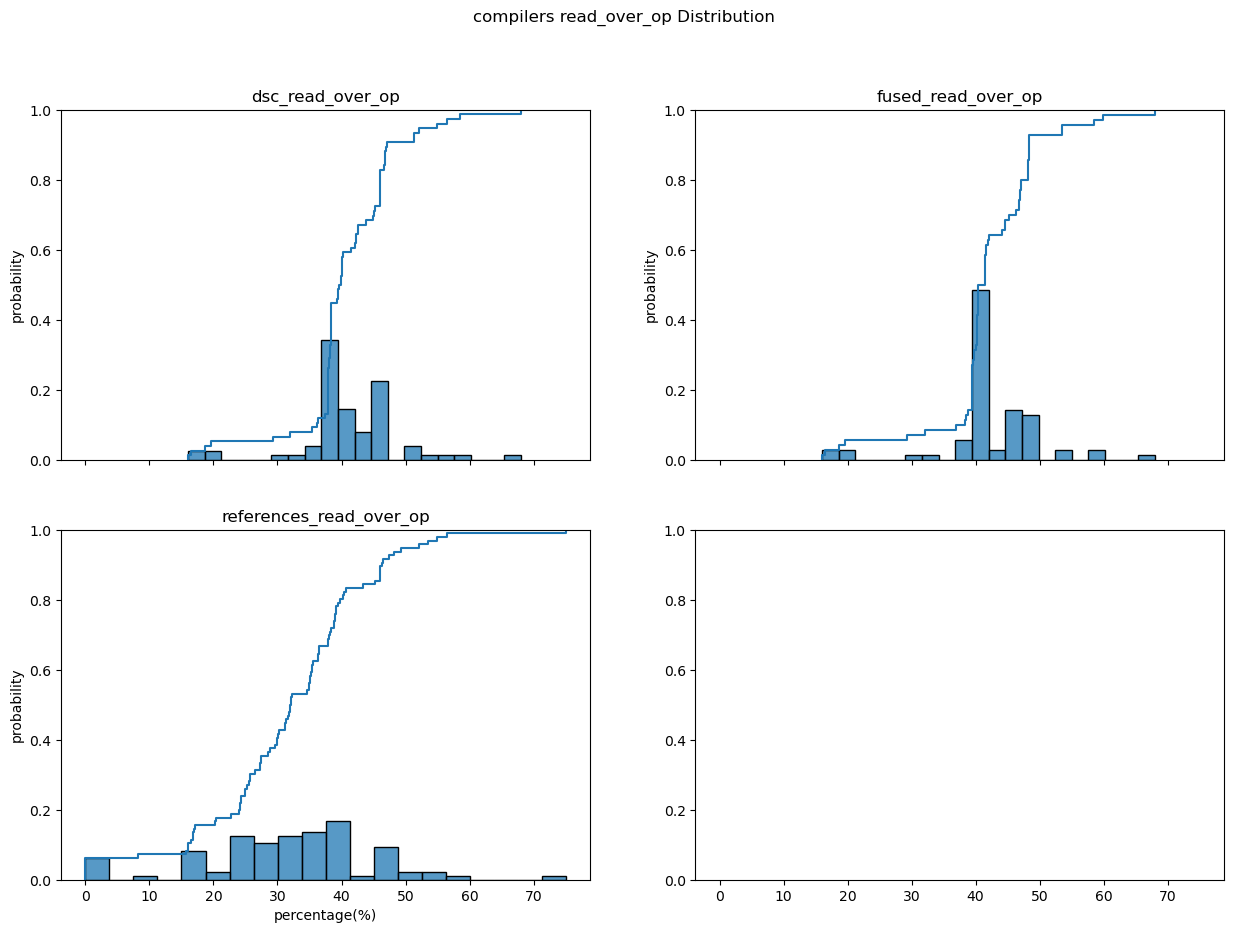

In [30]:
plot_grouop_ratio('read_over_op', 20)

NaN(dsc_write_over_read):  0 []
data_length(dsc_write_over_read) 76
NaN(dsc-fused-operator_write_over_read):  0 []
data_length(dsc-fused-operator_write_over_read) 70
NaN(references_write_over_read):  6 [PosixPath('../optimizations/references/tracefiles_long/controllable/approve'), PosixPath('../optimizations/references/tracefiles_long/erc777/approve'), PosixPath('../optimizations/references/tracefiles_long/link/approve'), PosixPath('../optimizations/references/tracefiles_long/shib/approve'), PosixPath('../optimizations/references/tracefiles_long/bnb/approve'), PosixPath('../optimizations/references/tracefiles_long/ltcSwapAsset/approve')]
data_length(references_write_over_read) 90


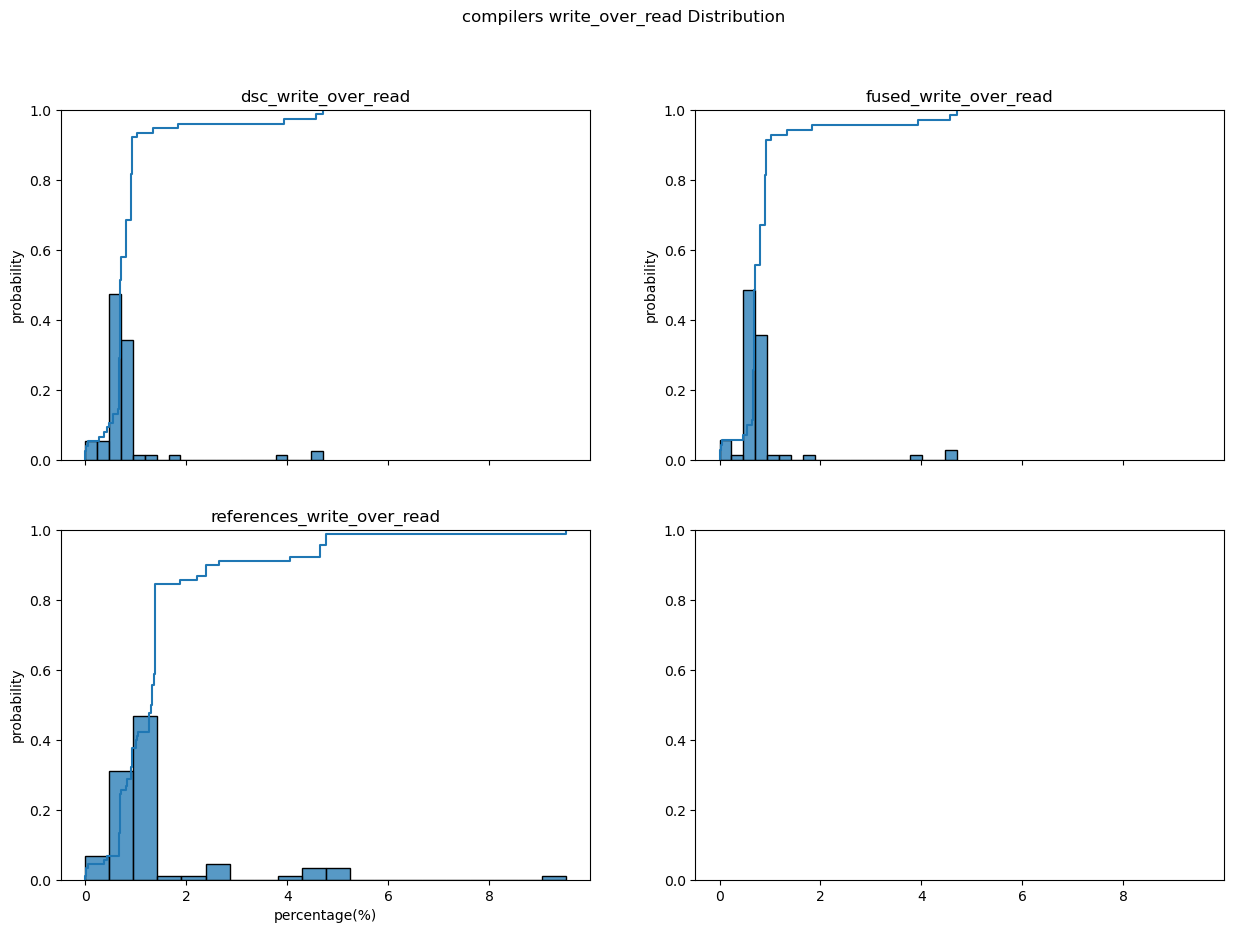

In [33]:
plot_grouop_ratio('write_over_read', 20)

NaN(dsc_read_over_write):  2 [PosixPath('../optimizations/dsc/tracefiles_long/crowdsale/withdraw'), PosixPath('../optimizations/dsc/tracefiles_long/bnb/withdrawEther')]
data_length(dsc_read_over_write) 74
NaN(dsc-fused-operator_read_over_write):  2 [PosixPath('../optimizations/dsc-fused-operator/tracefiles_long/crowdsale/withdraw'), PosixPath('../optimizations/dsc-fused-operator/tracefiles_long/bnb/withdrawEther')]
data_length(dsc-fused-operator_read_over_write) 68
NaN(references_read_over_write):  1 [PosixPath('../optimizations/references/tracefiles_long/bnb/withdrawEther')]
data_length(references_read_over_write) 95


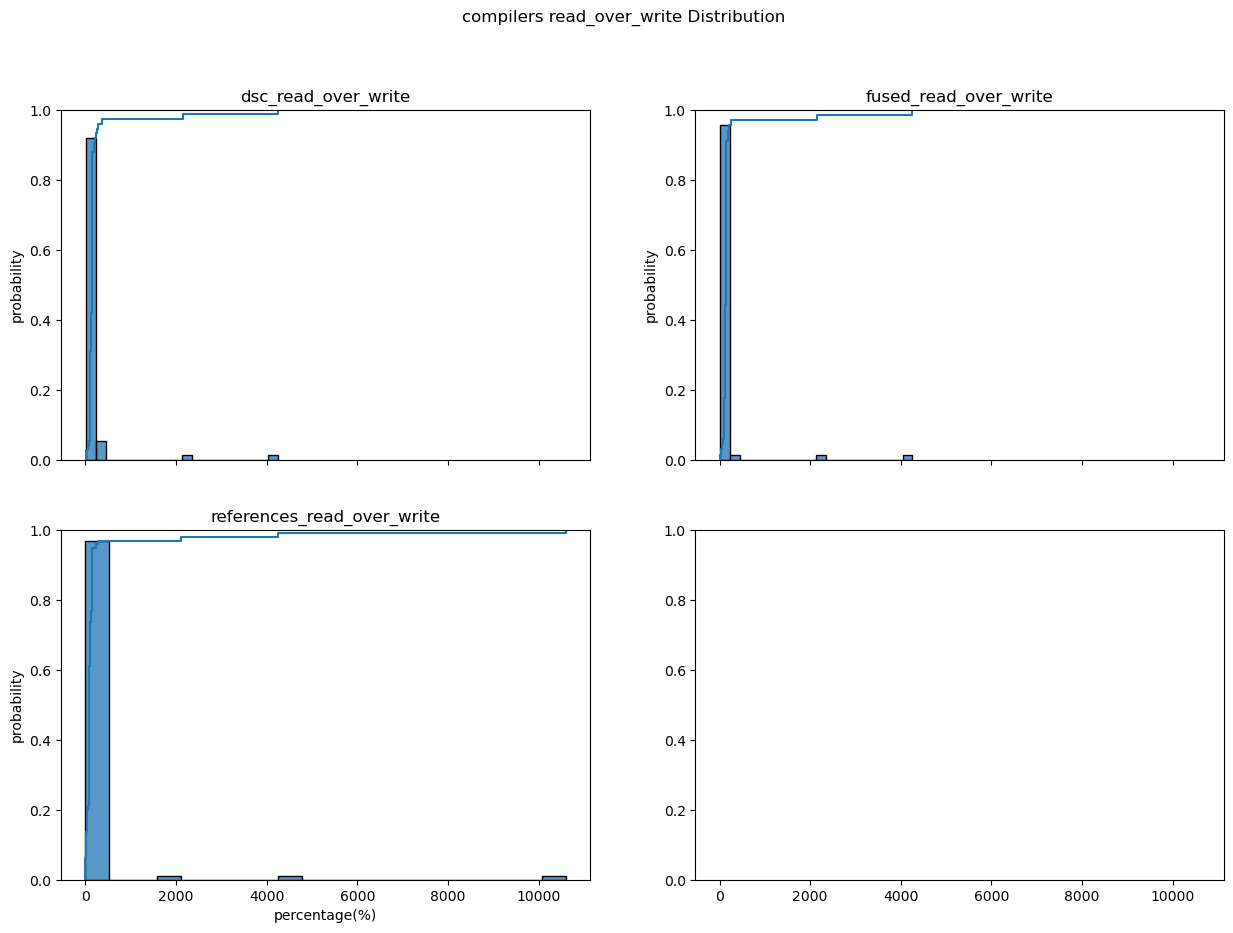

In [31]:
plot_grouop_ratio('read_over_write', 20)